# Determining the cost of cars

Service for the sale of used cars "Not beaten, not painted" is developing an application to attract new customers. In it you can quickly find out the market value of your car. We have historical data at our disposal: technical characteristics, configurations and prices of cars. We need to build a model to determine the cost.

For the customer is important:

- quality of prediction;
- prediction speed;
- studying time.

Features:

* DateCrawled - date of downloading the profile from the database
* VehicleType - type of car body
* RegistrationYear - year of registration of the car
* Gearbox - type of gearbox
* Power - power (hp)
* Model - car model
* Kilometer - mileage (km)
* RegistrationMonth - month of car registration
* FuelType - type of fuel
* Brand - car brand
* NotRepaired - was the car under repair or not
* DateCreated - date of creation of the profile
* NumberOfPictures - the number of photos of the car
* PostalCode - postal code of the owner of the profile (user)
* LastSeen - date of last user activity

Target feature:

* Price - price (EUR)

## Content
1. [Data preparation](#preprocessing)
2. [Model training](#learning)
3. [Model analysis](#analysis)

## Data preparation<a id="preprocessing"></a>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import time

import warnings
warnings.filterwarnings("ignore")

#autos = pd.read_csv('autos.csv')
autos = pd.read_csv('/datasets/autos.csv')

In [2]:
autos.info()
autos.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Preliminary analysis revealed the presence of gaps in individual columns.

Let's move on to detailed analysis and processing.

In [3]:
print('Количество дубликатов до удаления:', autos.duplicated().sum())

Количество дубликатов до удаления: 4


In [4]:
autos.drop_duplicates(inplace=True)
print('Количество дубликатов после удаления:', autos.duplicated().sum())

Количество дубликатов после удаления: 0


Checked for complete duplicates. Their small number (4) allows them to be removed without problems, which was done.

In [5]:
autos.columns = autos.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
autos.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

For the convenience of working with data, the column names were processed - writing all letters in lowercase and separating the words from each other by underscore.

In [6]:
autos['date_crawled'].sort_values(ascending=False)

90713     2016-04-07 14:36:58
339649    2016-04-07 14:36:56
301030    2016-04-07 14:36:55
53739     2016-04-07 14:36:54
204218    2016-04-07 14:36:53
                 ...         
99885     2016-03-05 14:06:24
324763    2016-03-05 14:06:24
176823    2016-03-05 14:06:24
220583    2016-03-05 14:06:23
329497    2016-03-05 14:06:22
Name: date_crawled, Length: 354365, dtype: object

For further analysis, the values of the date of downloading the questionnaire from the database (date_crawled) sorted in descending order were checked and it was noted that the data were presented for a relatively short period from March 5, 2016 to April 7, 2016. The year of registration of the car cannot be more than 2016.

In [7]:
autos.drop(['date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 
         'postal_code', 'last_seen'], axis=1, inplace=True)

In [8]:
autos.info()
autos.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
price                354365 non-null int64
vehicle_type         316875 non-null object
registration_year    354365 non-null int64
gearbox              334532 non-null object
power                354365 non-null int64
model                334660 non-null object
kilometer            354365 non-null int64
fuel_type            321470 non-null object
brand                354365 non-null object
not_repaired         283211 non-null object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN


According to the results of visual analysis, it was found that some of the features cannot have a direct impact on the target feature price, namely the following features: the date the profile was downloaded from the database, the month the car was registered, the date the profile was created, the number of photos, the postal code of the owner and the date of the last user activity. They have all been completely removed from the data.

In [9]:
autos.isnull().sum().sort_values(ascending=False) / autos.shape[0]

not_repaired         0.200793
vehicle_type         0.105795
fuel_type            0.092828
gearbox              0.055968
model                0.055607
brand                0.000000
kilometer            0.000000
power                0.000000
registration_year    0.000000
price                0.000000
dtype: float64

The presence of gaps in 5 features was noted: was the car under repair or not, type of car body, type of fuel, type of gearbox and car model. In the first three cases, the percentage of omissions is especially significant.

At the same time, according to the experience of past works, in order to improve the accuracy of predictions and reduce the likelihood of retraining models, it is desirable not to use artificial filling of models based on the available data. Fill in the gaps with the value unknown, which is what these gaps are.

In [10]:
autos['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

There are no outliers or incorrect values in the model attribute. Let's move on to filling.

In [11]:
autos['model'].fillna('unknown', inplace=True)
autos['model'].value_counts()

golf                  29232
other                 24420
3er                   19761
unknown               19705
polo                  13066
                      ...  
i3                        8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 251, dtype: int64

Let's move on to the next missing feature - gearbox.

In [12]:
autos['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [13]:
autos['gearbox'].fillna('unknown', inplace=True)
autos['gearbox'].value_counts()

manual     268249
auto        66283
unknown     19833
Name: gearbox, dtype: int64

With gearbox values no anomalies were found - manual and automatic, and now also of an unknown design after filling in the gaps.

In [14]:
autos['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [15]:
autos['fuel_type'].value_counts()

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [16]:
autos['fuel_type'] = np.where(autos['fuel_type'] == 'gasoline', 'petrol', autos['fuel_type'])

In [17]:
autos['fuel_type'].unique()

array(['petrol', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

In [18]:
autos['fuel_type'].fillna('unknown', inplace=True)
autos['fuel_type'].value_counts()

petrol      315068
unknown      32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In the type of fuel, two similar values were found - petrol and gasoline, which mean the same thing. Since there are more petrol values, all gasoline values have been changed to petrol. Gaps are replaced with unknown.

In [19]:
autos['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [20]:
autos['vehicle_type'].fillna('unknown', inplace=True)
autos['vehicle_type'].value_counts()

sedan          91457
small          79830
wagon          65165
unknown        37490
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64

In the type of car body, no outstanding values were found. Gaps are filled with unknown value.

In [21]:
autos['not_repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [22]:
autos['not_repaired'].fillna('unknown', inplace=True)
autos['not_repaired'].value_counts()

no         247158
unknown     71154
yes         36053
Name: not_repaired, dtype: int64

Based on the results of filling in the gaps in the category "was the car under repair or not", it contains only three values: yes, no, and unknown.

Let's move on to the analysis of numerical data, which are presented in the price, registration_year, power, and kilometer features.

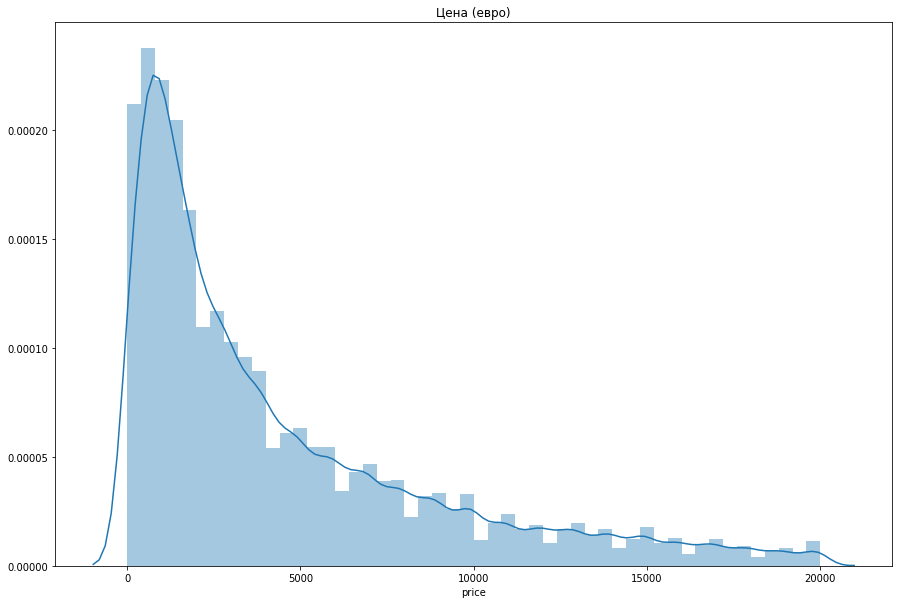

In [23]:
plt.figure(figsize=(15,10))
sns.distplot(autos['price'])
plt.title('Цена (евро)')
plt.show()

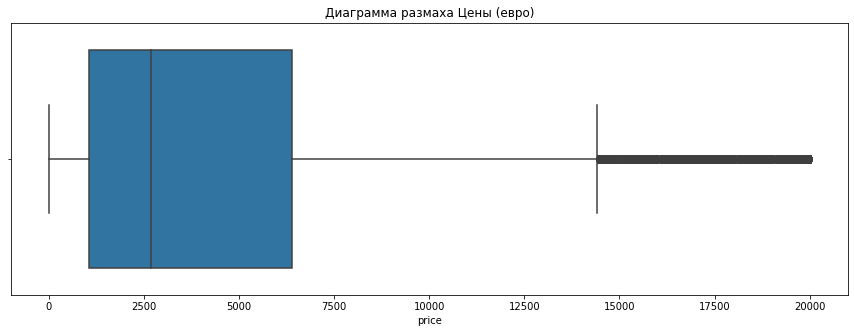

In [24]:
plt.figure(figsize=(15,5))
sns.boxplot(autos['price'])
plt.title('Диаграмма размаха Цены (евро)')
plt.show()

In [25]:
autos.query('price == 0')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,unknown,1990,unknown,0,corsa,150000,petrol,opel,unknown
111,0,unknown,2017,manual,0,golf,5000,petrol,volkswagen,unknown
115,0,small,1999,unknown,0,unknown,5000,petrol,volkswagen,unknown
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
...,...,...,...,...,...,...,...,...,...,...
354205,0,unknown,2000,manual,65,corsa,150000,unknown,opel,yes
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,unknown
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,unknown
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes


In [26]:
autos.query('price < 50 and price != 0').sort_values(by=['price'], ascending=False)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
129471,49,unknown,1980,unknown,0,transporter,10000,unknown,volkswagen,unknown
244980,49,unknown,1995,unknown,0,unknown,100000,unknown,bmw,unknown
343717,49,unknown,1995,unknown,0,unknown,100000,unknown,bmw,unknown
19672,49,unknown,1990,unknown,0,unknown,100000,unknown,bmw,unknown
7335,49,unknown,1995,unknown,0,passat,150000,unknown,volkswagen,unknown
...,...,...,...,...,...,...,...,...,...,...
143031,1,small,1989,manual,129,golf,150000,petrol,volkswagen,no
142805,1,bus,2011,manual,105,golf,125000,petrol,volkswagen,yes
142330,1,sedan,1992,manual,90,80,150000,petrol,audi,unknown
142270,1,unknown,1990,unknown,100,golf,150000,unknown,volkswagen,unknown


In [27]:
autos = autos.query('price != 0 and price >= 50')
autos.info()
autos.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341942 entries, 0 to 354368
Data columns (total 10 columns):
price                341942 non-null int64
vehicle_type         341942 non-null object
registration_year    341942 non-null int64
gearbox              341942 non-null object
power                341942 non-null int64
model                341942 non-null object
kilometer            341942 non-null int64
fuel_type            341942 non-null object
brand                341942 non-null object
not_repaired         341942 non-null object
dtypes: int64(4), object(6)
memory usage: 28.7+ MB


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,unknown
9,999,small,1998,manual,101,golf,150000,unknown,volkswagen,unknown
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no


Zero values were found in the price feature (about 3% of the total), which were removed. The rest of the distribution of this feature looks normal.

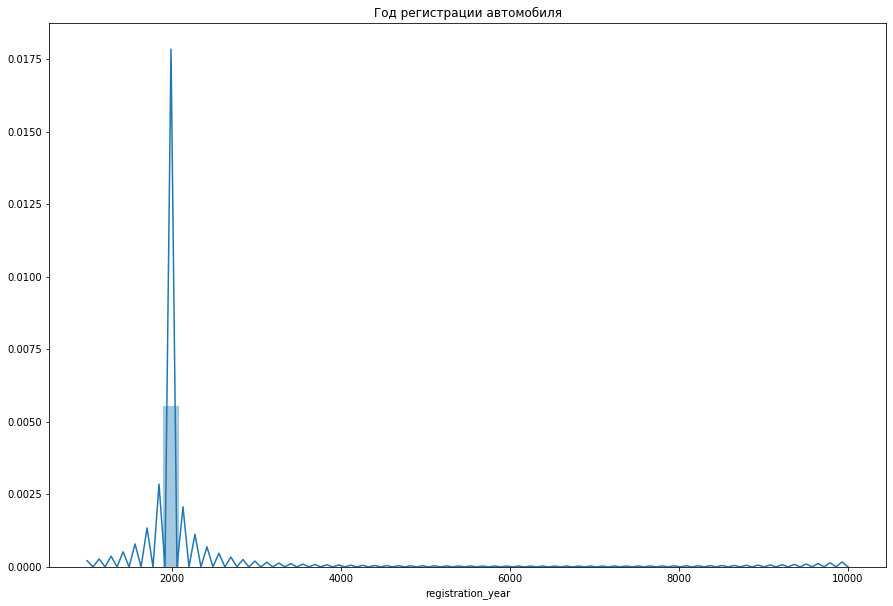

In [28]:
plt.figure(figsize=(15,10))
sns.distplot(autos['registration_year'])
plt.title('Год регистрации автомобиля')
plt.show()

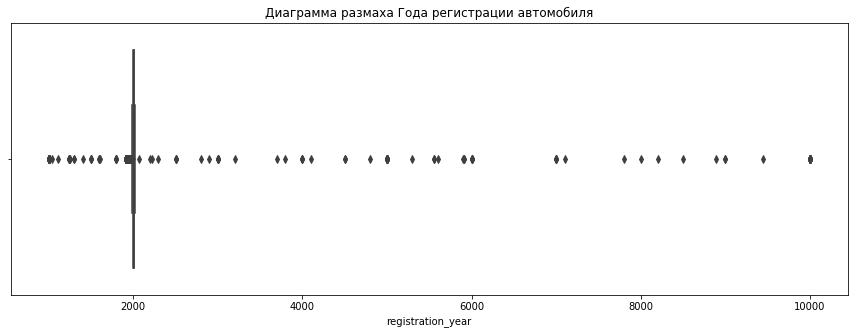

In [29]:
plt.figure(figsize=(15,5))
sns.boxplot(autos['registration_year'])
plt.title('Диаграмма размаха Года регистрации автомобиля')
plt.show()

The graphs show a large number of anomalous values expressed in too late years of registration (more than the maximum year of downloading the questionnaire, 2016) and too early years (less than a reasonable period for the mass presence of certain cars on the go, 1980).

In [30]:
autos.query('registration_year < 1980 or registration_year > 2016')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
15,450,small,1910,unknown,0,ka,5000,petrol,ford,unknown
22,2900,unknown,2018,manual,90,meriva,150000,petrol,opel,no
26,5555,unknown,2017,manual,125,c4,125000,unknown,citroen,no
48,7750,unknown,2017,manual,80,golf,100000,petrol,volkswagen,unknown
51,2000,unknown,2017,manual,90,punto,150000,petrol,fiat,yes
...,...,...,...,...,...,...,...,...,...,...
354203,2140,unknown,2018,manual,80,fiesta,150000,unknown,ford,no
354253,1250,unknown,2018,unknown,0,corsa,150000,petrol,opel,unknown
354286,16500,coupe,1973,manual,200,other,150000,petrol,bmw,yes
354289,5000,unknown,2017,manual,120,other,150000,unknown,citroen,yes


In [31]:
autos = autos.query('registration_year >= 1980 and registration_year <= 2016')
autos.info()
autos.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325150 entries, 0 to 354368
Data columns (total 10 columns):
price                325150 non-null int64
vehicle_type         325150 non-null object
registration_year    325150 non-null int64
gearbox              325150 non-null object
power                325150 non-null int64
model                325150 non-null object
kilometer            325150 non-null int64
fuel_type            325150 non-null object
brand                325150 non-null object
not_repaired         325150 non-null object
dtypes: int64(4), object(6)
memory usage: 27.3+ MB


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,unknown
9,999,small,1998,manual,101,golf,150000,unknown,volkswagen,unknown
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no


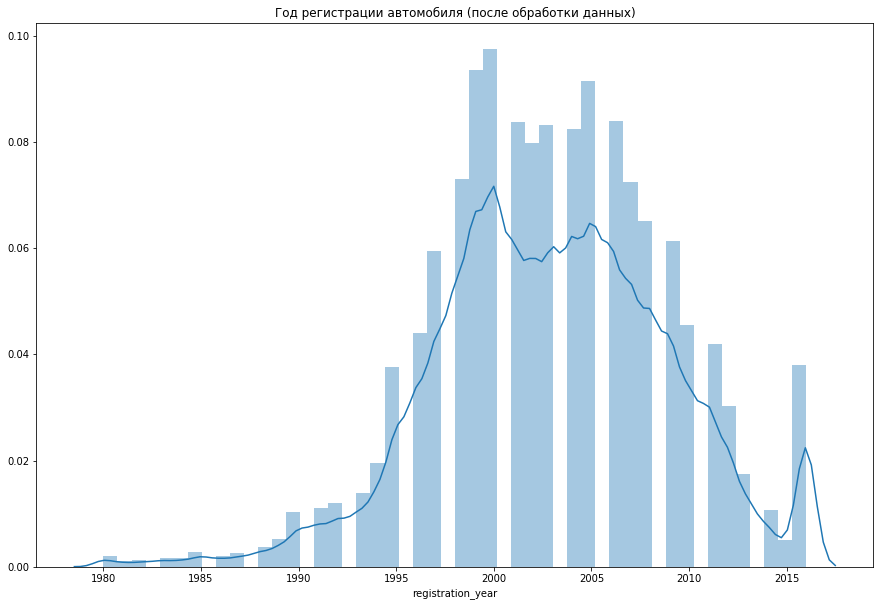

In [32]:
plt.figure(figsize=(15,10))
sns.distplot(autos['registration_year'])
plt.title('Год регистрации автомобиля (после обработки данных)')
plt.show()

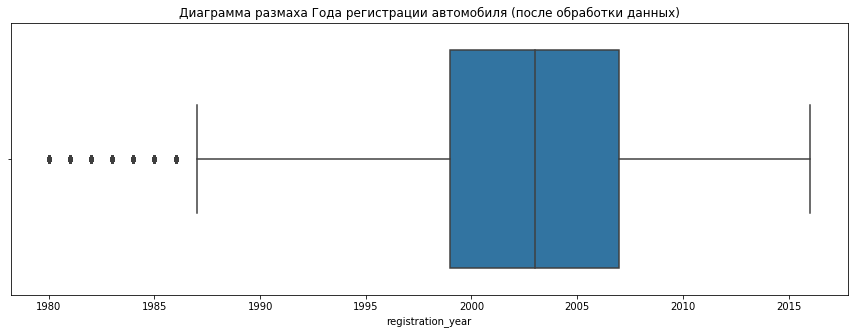

In [33]:
plt.figure(figsize=(15,5))
sns.boxplot(autos['registration_year'])
plt.title('Диаграмма размаха Года регистрации автомобиля (после обработки данных)')
plt.show()

There were 16 792 data related to the boundaries of the car’s production date of less than 1980 and more than 2016, which we determined. They have been removed.

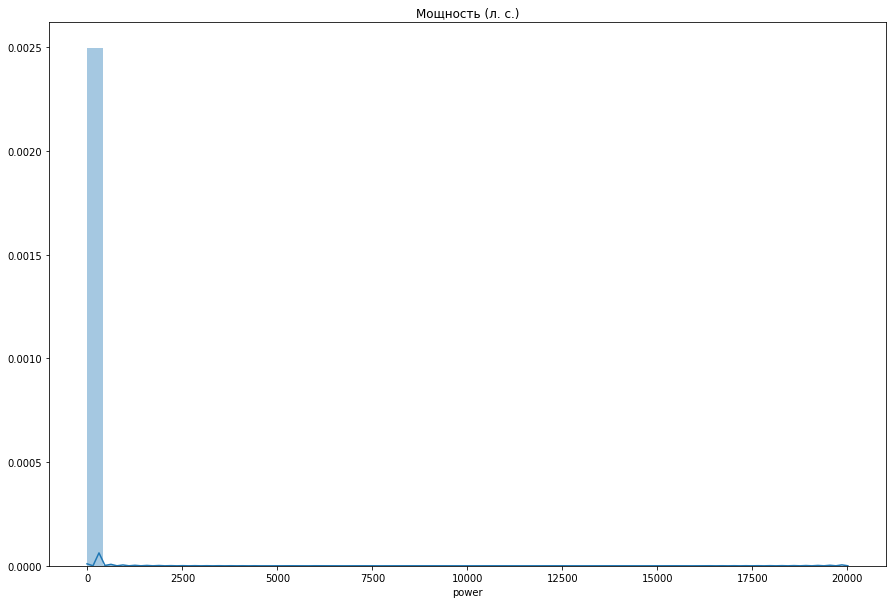

In [34]:
plt.figure(figsize=(15,10))
sns.distplot(autos['power'])
plt.title('Мощность (л. с.)')
plt.show()

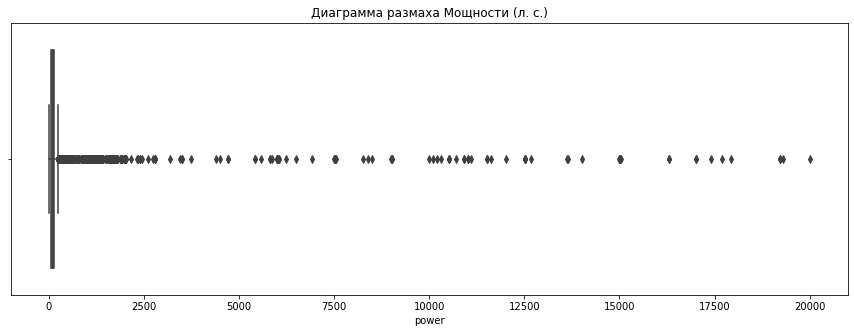

In [35]:
plt.figure(figsize=(15,5))
sns.boxplot(autos['power'])
plt.title('Диаграмма размаха Мощности (л. с.)')
plt.show()

In [36]:
autos.query('power == 0')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
32,245,sedan,1994,unknown,0,golf,150000,petrol,volkswagen,no
37,1500,unknown,2016,unknown,0,kangoo,150000,petrol,renault,no
54,4700,wagon,2005,manual,0,signum,150000,unknown,opel,no
55,550,wagon,1999,manual,0,astra,150000,petrol,opel,yes
...,...,...,...,...,...,...,...,...,...,...
354336,3299,unknown,2005,auto,0,outlander,150000,petrol,mitsubishi,unknown
354338,180,unknown,1995,unknown,0,unknown,125000,petrol,opel,unknown
354346,2600,unknown,2005,auto,0,c_klasse,150000,unknown,mercedes_benz,unknown
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no


In [37]:
autos.query('power > 500')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
4060,3100,sedan,2005,manual,953,colt,150000,petrol,mitsubishi,no
5328,500,wagon,1999,manual,1001,astra,150000,petrol,opel,unknown
6296,599,small,2002,manual,603,matiz,5000,petrol,chevrolet,yes
6504,3000,small,2009,manual,771,punto,125000,petrol,fiat,unknown
...,...,...,...,...,...,...,...,...,...,...
348883,7500,sedan,2011,manual,1548,scenic,90000,petrol,renault,unknown
348968,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes
351947,1500,bus,2001,manual,1001,zafira,5000,petrol,opel,no
353633,2400,sedan,2007,manual,650,c2,150000,petrol,citroen,unknown


In [38]:
autos.query('power < 20 and power != 0')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
431,3950,small,2004,auto,5,unknown,70000,petrol,sonstige_autos,no
3349,1990,small,2004,unknown,7,polo,150000,petrol,volkswagen,no
4637,870,wagon,2000,manual,16,focus,150000,unknown,ford,no
9561,9000,sedan,2009,manual,2,a4,5000,petrol,audi,unknown
12571,5999,small,2014,auto,15,other,10000,electric,renault,no
...,...,...,...,...,...,...,...,...,...,...
348891,5690,small,2014,auto,18,other,10000,electric,renault,no
348975,1850,small,2003,auto,5,unknown,50000,petrol,sonstige_autos,yes
349666,1500,unknown,2016,unknown,2,unknown,150000,petrol,volkswagen,unknown
353127,8600,convertible,2012,manual,8,unknown,5000,petrol,sonstige_autos,no


Based on the results of the analysis of power indicators, a significant number of zero values in the amount of 35 361 pieces (more than 10%) were noted, as well as anomalous values exceeding even the maximum reasonable threshold (500 hp) taken with a margin, and small values that are lower a minimum reasonable threshold of 20 hp, in the amount of 383 and 293 pieces, respectively. To improve the performance of the model, it was decided to completely exclude values more than 500 hp and less than 20 hp, and fill in zero values.

In [39]:
autos = autos.query('power <= 500')

In [40]:
autos.info()
autos.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324767 entries, 0 to 354368
Data columns (total 10 columns):
price                324767 non-null int64
vehicle_type         324767 non-null object
registration_year    324767 non-null int64
gearbox              324767 non-null object
power                324767 non-null int64
model                324767 non-null object
kilometer            324767 non-null int64
fuel_type            324767 non-null object
brand                324767 non-null object
not_repaired         324767 non-null object
dtypes: int64(4), object(6)
memory usage: 27.3+ MB


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,unknown
9,999,small,1998,manual,101,golf,150000,unknown,volkswagen,unknown
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no


In [41]:
autos = autos.query('power >= 20 or power == 0')

In [42]:
autos.info()
autos.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324474 entries, 0 to 354368
Data columns (total 10 columns):
price                324474 non-null int64
vehicle_type         324474 non-null object
registration_year    324474 non-null int64
gearbox              324474 non-null object
power                324474 non-null int64
model                324474 non-null object
kilometer            324474 non-null int64
fuel_type            324474 non-null object
brand                324474 non-null object
not_repaired         324474 non-null object
dtypes: int64(4), object(6)
memory usage: 27.2+ MB


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,unknown
9,999,small,1998,manual,101,golf,150000,unknown,volkswagen,unknown
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no


In [43]:
autos['power'].replace(0, np.nan, inplace=True)

In [44]:
power_dict = (
    autos
    .pivot_table(index=['vehicle_type', 'registration_year', 'model'], 
                 values='power', 
                 aggfunc='median')
)

In [45]:
def power_index(row):
    vehicle_type = row['vehicle_type']
    registration_year = row['registration_year']
    model = row['model']
    power_index = tuple([vehicle_type, registration_year, model])
    return power_index
autos['power_index'] = autos.apply(power_index, axis=1)

In [46]:
autos['power'] = (
    autos['power']
    .fillna(autos['power_index'].map(power_dict['power']))
)
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324474 entries, 0 to 354368
Data columns (total 11 columns):
price                324474 non-null int64
vehicle_type         324474 non-null object
registration_year    324474 non-null int64
gearbox              324474 non-null object
power                323343 non-null float64
model                324474 non-null object
kilometer            324474 non-null int64
fuel_type            324474 non-null object
brand                324474 non-null object
not_repaired         324474 non-null object
power_index          324474 non-null object
dtypes: float64(1), int64(3), object(7)
memory usage: 29.7+ MB


After filling power with categorization by vehicle_type, registration_year and model with the calculation of the median for each of the possible options. 1 131 values out of 31 221 remained unfilled.

In [47]:
autos.dropna(subset = ['power'], inplace = True)
autos = autos.drop('power_index', axis=1)
autos.reset_index(drop=True, inplace=True)
autos['power'] = autos['power'].astype('int64')
autos.info()
autos.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323343 entries, 0 to 323342
Data columns (total 10 columns):
price                323343 non-null int64
vehicle_type         323343 non-null object
registration_year    323343 non-null int64
gearbox              323343 non-null object
power                323343 non-null int64
model                323343 non-null object
kilometer            323343 non-null int64
fuel_type            323343 non-null object
brand                323343 non-null object
not_repaired         323343 non-null object
dtypes: int64(4), object(6)
memory usage: 24.7+ MB


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,unknown,1993,manual,90,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,14500,bus,2014,manual,125,c_max,30000,petrol,ford,unknown
8,999,small,1998,manual,101,golf,150000,unknown,volkswagen,unknown
9,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no


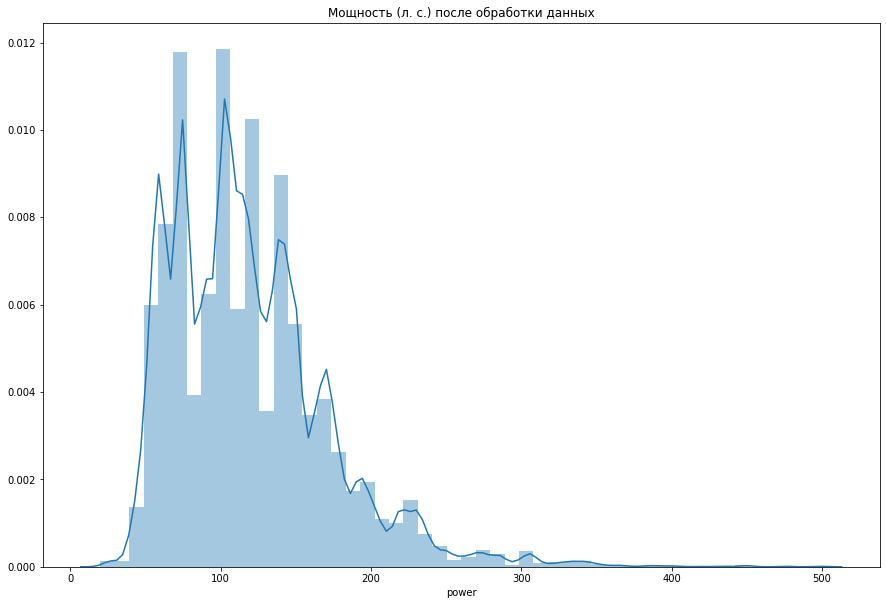

In [48]:
plt.figure(figsize=(15,10))
sns.distplot(autos['power'])
plt.title('Мощность (л. с.) после обработки данных')
plt.show()

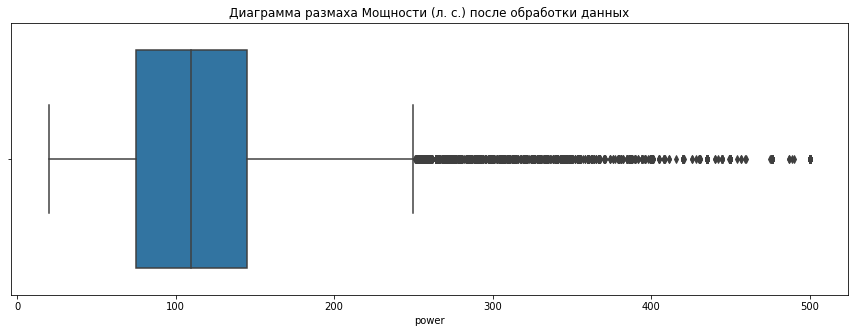

In [49]:
plt.figure(figsize=(15,5))
sns.boxplot(autos['power'])
plt.title('Диаграмма размаха Мощности (л. с.) после обработки данных')
plt.show()

Power values that were not filled in by categorization were removed along with the power_index column, which was no longer needed. Graphs after processing took a "normal" form.

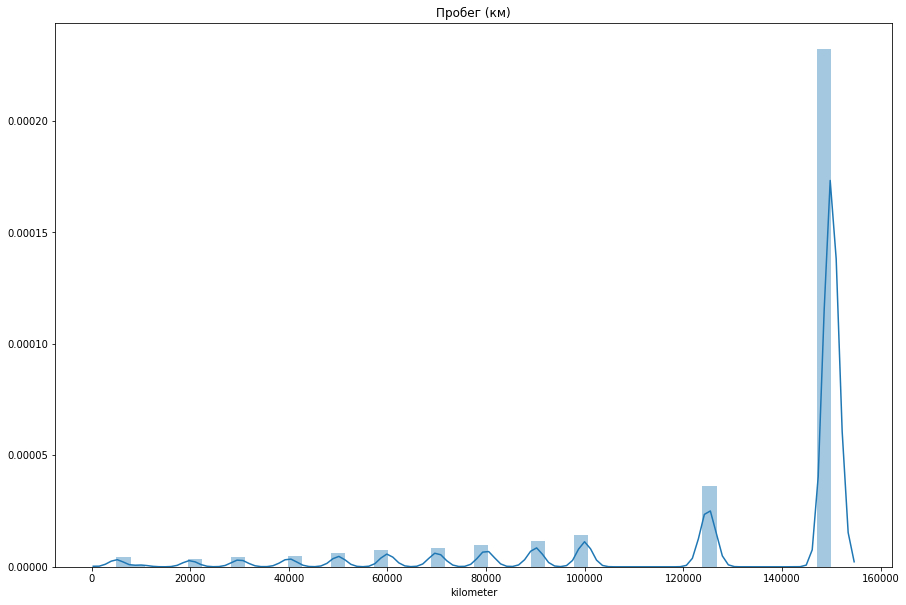

In [50]:
plt.figure(figsize=(15,10))
sns.distplot(autos['kilometer'])
plt.title('Пробег (км)')
plt.show()

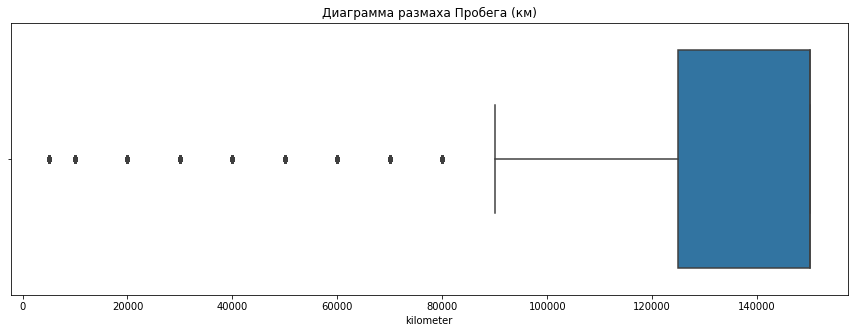

In [51]:
plt.figure(figsize=(15,5))
sns.boxplot(autos['kilometer'])
plt.title('Диаграмма размаха Пробега (км)')
plt.show()

According to the results of the analysis, there is no need to process the mileage indicator.

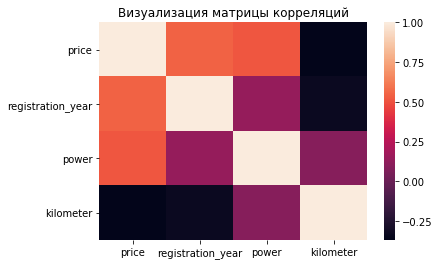

In [52]:
sns.heatmap(autos.corr())
plt.title('Визуализация матрицы корреляций')
plt.show()

Based on the results of the data preparation, the correlation of the columns was checked, which showed a very weak correlation between cost and mileage, but a good one between cost and year of registration, and power.

## Model training<a id="learning"></a>

In [53]:
numeric = ['registration_year', 'power', 'kilometer']
categorial = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
autos[categorial] = autos[categorial].astype('category')

In [54]:
features = autos.drop('price', axis=1)
target = autos['price']

Let's prepare the data by dividing it into features and target feature, as well as extracting numerical and categorical features from features.

In [55]:
features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.25, 
                                                                              random_state=12345)

In [56]:
features_train.shape

(242507, 9)

In [57]:
target_train.shape

(242507,)

In [58]:
features_valid.shape

(80836, 9)

In [59]:
target_valid.shape

(80836,)

To split the data into two samples (training and validation), the train_test_split method was used. The sampling ratio was 3:1 or 75%:25%. Dimension check completed successfully.

In [60]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

Let's scale the numerical data using the Standard Scaler.

In [61]:
models_scores = pd.DataFrame(columns = ['model', 'rmse', 'learn_time', 'predict_time'])

In [62]:
%%time
dummy = DummyRegressor(strategy='mean')
start_time = time.time()
dummy.fit(features_train, target_train)
learn_time_dummy = time.time() - start_time
start_time = time.time()
prediction = dummy.predict(features_valid)
predict_time_dummy = time.time() - start_time
score_dummy = mean_squared_error(target_valid, prediction) ** 0.5

print(f'RMSE для Dummy: {score_dummy}')

models_scores = models_scores.append({'model': 'DummyRegressor', 'rmse': score_dummy,
                    'learn_time': learn_time_dummy, 'predict_time': predict_time_dummy}, ignore_index=True)

RMSE для Dummy: 4522.992880214837
CPU times: user 5.08 ms, sys: 1.44 ms, total: 6.52 ms
Wall time: 7.49 ms


In [63]:
%%time
best_score_lgbm = 10000
best_depth_lgbm = 0
best_est_lgbm = 0
best_learn_time_lgbm = 0
best_predict_time_lgbm = 0
for depth in range(1, 25):
    for est in range(1, 25):
        lgbm = LGBMRegressor(max_depth=depth, n_estimators=est, random_state=12345)
        start_time = time.time()
        lgbm.fit(features_train, target_train)
        learn_time_lgbm = time.time() - start_time
        start_time = time.time()
        prediction = lgbm.predict(features_valid)
        predict_time_lgbm = time.time() - start_time
        score_lgbm = mean_squared_error(target_valid, prediction) ** 0.5
        if score_lgbm < best_score_lgbm:
            best_score_lgbm = score_lgbm
            best_depth_lgbm = depth
            best_est_lgbm = est
            best_learn_time_lgbm = learn_time_lgbm
            best_predict_time_lgbm = predict_time_lgbm
print(f'Лучший RMSE для LGBM: {best_score_lgbm}, Лучший max_depth: {best_depth_lgbm}, Лучший est: {best_est_lgbm}')

models_scores = models_scores.append({'model': 'LGBMRegressor', 'rmse': best_score_lgbm,
                    'learn_time': best_learn_time_lgbm, 'predict_time': best_predict_time_lgbm}, ignore_index=True)

Лучший RMSE для LGBM: 1812.6290811444192, Лучший max_depth: 9, Лучший est: 24
CPU times: user 8min 20s, sys: 8.66 s, total: 8min 29s
Wall time: 2min 14s


In [64]:
%%time
best_score_catboost = 10000
best_depth_catboost = 0
best_iteration_catboost = 0
best_learn_time_catboost = 0
best_predict_time_catboost = 0
for depth in range(1, 16):
    for iteration in range(1, 25):
        catboost = CatBoostRegressor(depth=depth, iterations=iteration, cat_features=categorial, random_state=12345)
        start_time = time.time()
        catboost.fit(features_train, target_train)
        learn_time_catboost = time.time() - start_time
        start_time = time.time()
        prediction = catboost.predict(features_valid)
        predict_time_catboost = time.time() - start_time
        score_catboost = mean_squared_error(target_valid, prediction) ** 0.5
        if score_catboost < best_score_catboost:
            best_score_catboost = score_catboost
            best_depth_catboost = depth
            best_iteration_catboost = iteration
            best_learn_time_catboost = learn_time_catboost
            best_predict_time_catboost = predict_time_catboost
print(f'Лучший RMSE: {best_score_catboost}, Лучший max_depth: {best_depth_catboost}, Лучший iterations: {best_iteration_catboost}')

models_scores = models_scores.append({'model': 'CatBoostRegressor', 'rmse': best_score_catboost,
                    'learn_time': best_learn_time_catboost, 
                    'predict_time': best_predict_time_catboost}, ignore_index=True)

Learning rate set to 0.5
0:	learn: 3848.7688448	total: 75.7ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3848.7688448	total: 17.6ms	remaining: 17.6ms
1:	learn: 3498.0739796	total: 29.6ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3848.7688448	total: 16.6ms	remaining: 33.2ms
1:	learn: 3498.0739796	total: 28.5ms	remaining: 14.3ms
2:	learn: 3280.0734921	total: 40.1ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3848.7688448	total: 17.6ms	remaining: 52.8ms
1:	learn: 3498.0739796	total: 30.4ms	remaining: 30.4ms
2:	learn: 3280.0734921	total: 42.4ms	remaining: 14.1ms
3:	learn: 3137.7970876	total: 54ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3848.7688448	total: 17.7ms	remaining: 70.9ms
1:	learn: 3498.0739796	total: 29.9ms	remaining: 44.8ms
2:	learn: 3280.0734921	total: 41.5ms	remaining: 27.7ms
3:	learn: 3137.7970876	total: 53.3ms	remaining: 13.3ms
4:	learn: 3024.2160258	total: 72.8ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3848.7688448	total: 17.5ms	remai

We will select the parameters of the LightGBM and Catboost models, and also check the operation of the dummy classifier.

## Model analysis<a id="analysis"></a>

In [65]:
models_scores

,model,rmse,learn_time,predict_time
0,DummyRegressor,4522.992880,0.000622,0.000138
1,LGBMRegressor,1812.629081,0.276218,0.049307
2,CatBoostRegressor,1601.880032,7.426682,0.059959


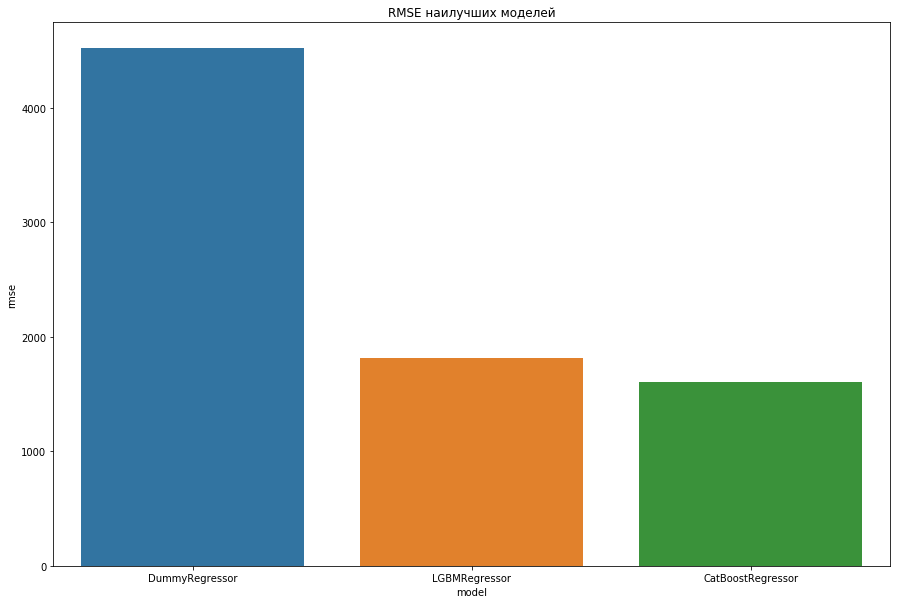

In [66]:
plt.figure(figsize=(15,10))
sns.barplot(x=models_scores['model'],y=models_scores['rmse'])
plt.title('RMSE наилучших моделей')
plt.show()

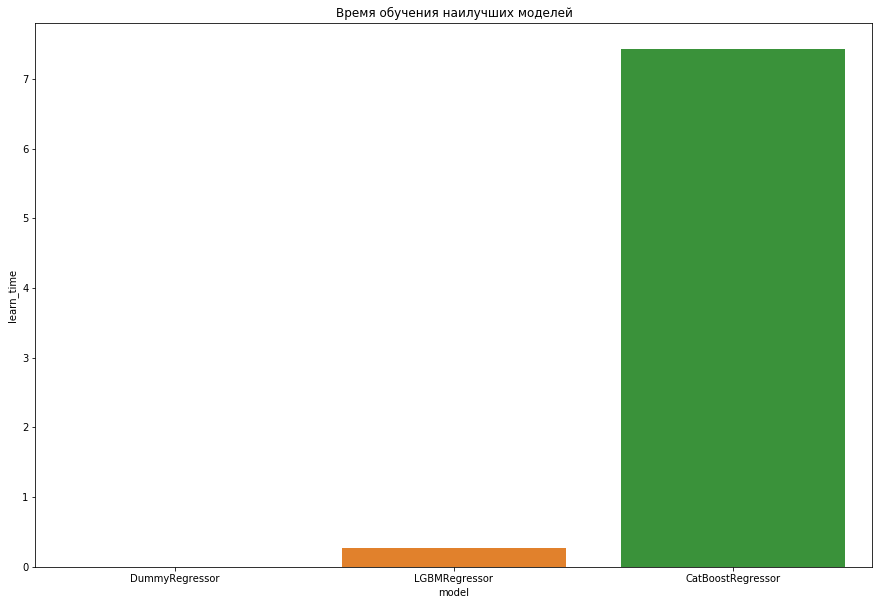

In [67]:
plt.figure(figsize=(15,10))
sns.barplot(x=models_scores['model'],y=models_scores['learn_time'])
plt.title('Время обучения наилучших моделей')
plt.show()

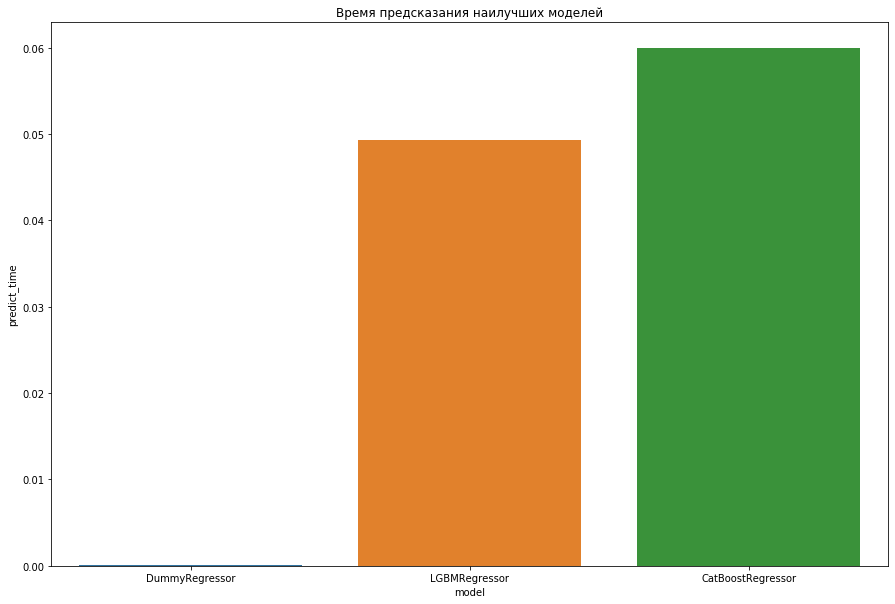

In [68]:
plt.figure(figsize=(15,10))
sns.barplot(x=models_scores['model'],y=models_scores['predict_time'])
plt.title('Время предсказания наилучших моделей')
plt.show()

According to the results of the work carried out, it was found that CatBoost, unlike LightGBM, shows a slightly better quality of predictions, but with a much longer operating time, especially training time. Dummy, by comparison, learns and predicts very quickly, but with terrible quality.

As a result, if the accuracy of the model is most important to the Customer, then the use of CatBoost should be recommended. If it is possible to sacrifice accuracy a little, but significantly increase the operating time, then LightGBM should be used.